In [2]:
%matplotlib inline 
import pandas as pd
import numpy as np
import xarray as xr
import os
import glob
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import norm
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import seaborn as sns
sns.set_style('white')
sns.set_context("notebook") #[poster, paper, talk, notebook]

## FUNCTIONS

In [3]:
def subregion_size(ds):
    dx = ds.x.max().values - ds.x.min().values
    dy = ds.y.max().values - ds.y.min().values
    return dx, dy


def plot_sd(ds, title, time=31, cmap='Blues', vmax=300):
    plt.figure(figsize=(10, 8))
    s = ds.isel(time=time)
    x_gt0 = s.snow.where(s.snow>0)
    x_gt0.plot.imshow(x='x', y='y', cmap=cmap, vmax=300, cbar_kwargs={'label': 'Snow Depth [cm]'})
    plt.tight_layout()

    
def plot_dem(ds, title, ctour_int=5, cmap='gray', ctour_lines='k'):
    plt.figure(figsize=(10, 8))
    levels = np.arange(ds.dem.min().values, ds.dem.max().values, ctour_int)
    h = ds.dem.plot.imshow(x='x', y='y', cmap=cmap, alpha=.9, cbar_kwargs={'label': 'Elevation [m]'})
    c = ds.dem.plot.contour(x='x',y='y', levels=levels, colors=ctour_lines, linewidths=.75)
    plt.clabel(c, levels, fmt='%1.0f')
    plt.title('{} \n{}'.format(title))
    plt.tight_layout()

    
def plot_veg_hgt(ds, title, ctour_int=5, cmap='Greens', ctour_lines='k'):
    plt.figure(figsize=(10, 8))
    #set up
    levels = np.around(np.arange(ds.dem.min().values, ds.dem.max().values, ctour_int), -1) #1000 m
#     levels = np.arange(ds.dem.min().values, ds.dem.max().values, ctour_int) # 150m, 30m
    #plot
    h = ts.hillshade.plot.imshow(x='x',y='y', cmap='gray', alpha=1, add_colorbar=False)
    v = ds.veg.plot.imshow(x='x', y='y', cmap=cmap, alpha=.7, vmax=30, cbar_kwargs={'label': 'Vegetation Height [m]'})
    c = ds.dem.plot.contour(x='x',y='y', levels=levels, colors=ctour_lines, linewidths=.75)
    plt.clabel(c, levels, fmt='%1.0f')
    plt.title('{}'.format(title))
    plt.tight_layout()


def plot_aspect(ts, title, slp_filter=10, ctour_int=5, ctour_lines='k'):
    plt.figure(figsize=(10, 8))
    #set up
    lvls = [0, 45, 90, 135, 180, 225, 270, 315, 360]
    levels = np.around(np.arange(ds.dem.min().values, ds.dem.max().values, ctour_int), -1) #1000 m
#   levels = np.arange(ds.dem.min().values, ds.dem.max().values, ctour_int) # 150m, 30m
    # labels = ['North', '', 'East', '', 'South', '', 'West'] #CANT MAKE THIS WORK, would be nice to lable cbar
    s_gt10 = ts.where(ts.slope>=slp_filter) #eliminate aspects where the slope is <10 deg
    #plot
    h = ts.hillshade.plot.imshow(x='x',y='y', cmap='gray', alpha=1, add_colorbar=False)
    a = s_gt10.aspect.plot.imshow(x='x', y='y', 
                                 colors= ['black','salmon','salmon','navajowhite','navajowhite', 'rebeccapurple','rebeccapurple','black'], 
                                 levels=lvls,
                                 alpha=.65,
                                 cbar_kwargs={'label': 'Aspect'})
    c = ds.dem.plot.contour(x='x',y='y', levels=levels, colors=ctour_lines, linewidths=.75)
    plt.clabel(c, levels, fmt='%1.0f')
    plt.title('{}'.format(title))
    plt.tight_layout()

    
def plot_slope(ts, title, s_gt=15, ctour_int=5, ctour_lines='k'):
    plt.figure(figsize=(10, 8))
    #set up
    levels = np.around(np.arange(ds.dem.min().values, ds.dem.max().values, ctour_int), -1) #1000 m
#   levels = np.arange(ds.dem.min().values, ds.dem.max().values, ctour_int) # 150m, 30m
    s_gt15 = ts.slope.where(ts.slope>s_gt)
    #plot
    h = ts.hillshade.plot.imshow(x='x',y='y', cmap='gray', alpha=1, add_colorbar=False)
    s = s_gt15.plot.imshow(x='x', y='y', 
                                 cmap='Wistia', 
                                 alpha=.65,
                                 cbar_kwargs={'label': 'slope'})
    c = ds.dem.plot.contour(x='x',y='y', levels=levels, colors=ctour_lines, linewidths=.75)
    plt.clabel(c, levels, fmt='%1.0f')
    plt.title('{}'.format(title))
    plt.tight_layout()


def plot_snow_series(ds, title, time=slice(2,51,5), cmap='Blues', vmax=300):
    plt.figure(figsize=(15, 10))
    s = ds.isel(time=time).snow.plot(x='x', y='y', col='time', 
                                              cmap=cmap, vmax=vmax, 
                                              cbar_kwargs={'label': 'Snow Depth [cm]'})

def z_score(ds, time=slice(1,51,1), exclude_zeros=True):
    ds = ds.isel(time=time)
    x_gt0 = ds.snow.where(ds.snow>0) #snow depth > 0cm
    
    if exclude_zeros is True:
        return (ds.snow - x_gt0.mean(dim=('x','y')) / x_gt0.std(dim=('x','y')))
    else: 
        return (ds.snow - ds.snow.mean(dim=('x','y')) / ds.snow.std(dim=('x','y')))
    

## DATA INPUTS

In [4]:
#~~~~~~LIDAR DATA
dx_input = 1000
flist1 = sorted(glob.glob('/Users/meganmason491/Documents/research/sierra/data/compiled_SUPERsnow_*{}m*'.format(dx_input))) #bsu
# flist1 = sorted(glob.glob('/Users/megmason/research/sierra/data/compiled_SUPERsnow_*150m*')) #mac
flist1

['/Users/meganmason491/Documents/research/sierra/data/compiled_SUPERsnow_1000m_dan.nc',
 '/Users/meganmason491/Documents/research/sierra/data/compiled_SUPERsnow_1000m_sli.nc',
 '/Users/meganmason491/Documents/research/sierra/data/compiled_SUPERsnow_1000m_tum.nc']

In [5]:
#~~~~~TERRAIN DATA
flist2 = sorted(glob.glob('/Users/meganmason491/Documents/research/sierra/data/terrain/terrainMet_*{}*'.format(dx_input))) #BSU
# flist_2 = '' #mac
flist2

['/Users/meganmason491/Documents/research/sierra/data/terrain/terrainMet_1000m_dan.nc',
 '/Users/meganmason491/Documents/research/sierra/data/terrain/terrainMet_1000m_sli.nc',
 '/Users/meganmason491/Documents/research/sierra/data/terrain/terrainMet_1000m_tum.nc']

## MAIN SCRIPT

In [ ]:
#Main, section 1:
stns = ['DAN','SLI','TUM'] #could make dict so it's always connected to the file, but shortcut is to do sorted(glob.glob) -- ie always loads in same order :/
stns_lc = ['dan','sli','tum']
stns_longname = ['Dana Meadow', 'Slide Canyon', 'Tuolumne Meadow']

for i, f in enumerate(zip(flist1, flist2)):
    
    f1, f2 = f
    
    print('Met Station Name:', stns_longname[i], '\n station ID:', stns[i])
    
    sns.set_style('white') # set up seaborn defaults (warnings w/o inside loop..?)
    sns.set_context("talk")

    ds = xr.open_dataset(f1); ds.close() #open lidar snow depth DataSet in Xarray -- ds
    ts = xr.open_dataset(f2); ts.close() #open terrain DataSet to access (hillslope, aspect, slope)

    dx, dy = subregion_size(ds) #subregion size -- used in figure naming

    plot_sd(ds, title=(stns_longname[i]))
#     plt.savefig('../figs/{}_sno_{}m.png'.format(stns_lc[i], int(dx)), dpi=300)
    
    plot_veg_hgt(ds, title=stns_longname[i], ctour_int=50) #plot veg of subregion (use 50 for 1000m)
#     plt.savefig('../figs/{}_veg_{}m.png'.format(stns_lc[i], int(dx)), dpi=300)

    plot_aspect(ts, title=stns_longname[i], ctour_int=50)
#     plt.savefig('../figs/{}_asp_{}m.png'.format(stns_lc[i], int(dx)), dpi=300)
    
    plot_slope(ts, title=stns_longname[i], ctour_int=50)
#     plt.savefig('../figs/{}_slp_{}m.png'.format(stns_lc[i], int(dx)), dpi=300)

Met Station Name: Dana Meadow 
 station ID: DAN
Met Station Name: Slide Canyon 
 station ID: SLI
Met Station Name: Tuolumne Meadow 
 station ID: TUM


<Figure size 1080x720 with 0 Axes>

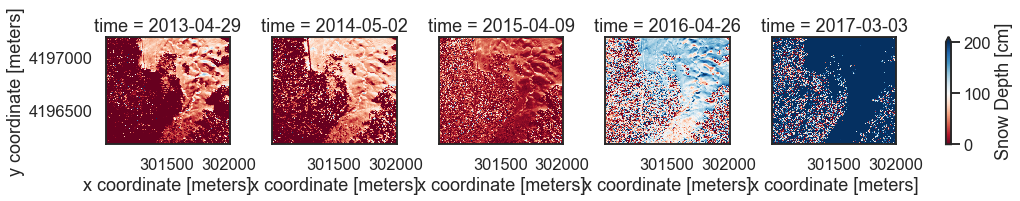

<Figure size 1080x720 with 0 Axes>

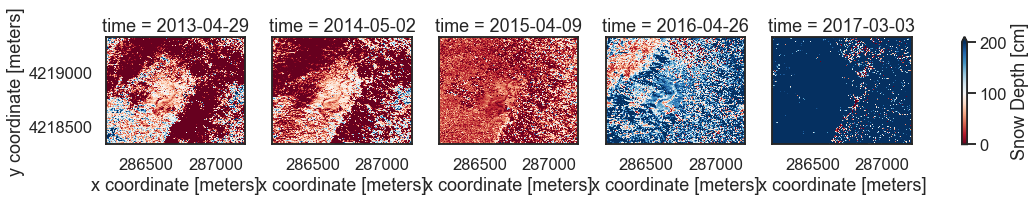

<Figure size 1080x720 with 0 Axes>

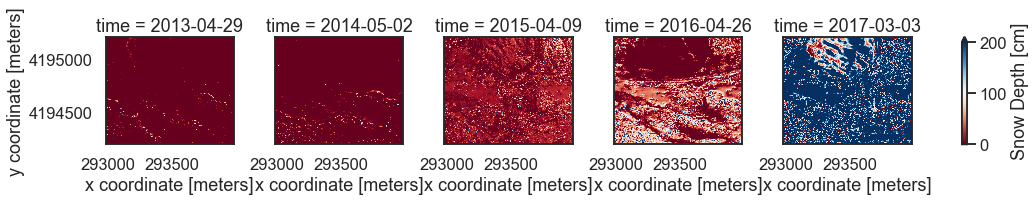

In [6]:
#Main, section 2: 
stns = ['DAN','SLI','TUM'] #could make dict so it's always connected to the file, but shortcut is to do sorted(glob.glob) -- ie always loads in same order :/
stns_lc = ['dan','sli','tum']
stns_longname = ['Dana Meadow', 'Slide Canyon', 'Tuolumne Meadow']

for i, f in enumerate(zip(flist1, flist2)):
    
    f1, f2 = f
    
    print('Met Station Name:', stns_longname[i], '\n station ID:', stns[i])
    
    sns.set_style('white') # set up seaborn defaults (warnings w/o inside loop..?)
    sns.set_context("talk")

    ds = xr.open_dataset(f1); ds.close() #open lidar snow depth DataSet in Xarray -- ds
    ts = xr.open_dataset(f2); ts.close() #open terrain DataSet to access (hillslope, aspect, slope)

    dx, dy = subregion_size(ds) #subregion size -- used in figure naming
    
    plot_snow_series(ds, title=stns_longname[i], time=slice(1,51,10), cmap='RdBu', vmax=200) #slice(1,51,10) [0,7,18,30,42,49]
#     plt.savefig('../figs/{}_sno_series{}m.png'.format(stns_lc[i], int(dx)), dpi=300)

Met Station Name: Dana Meadow 
 station ID: DAN


<Figure size 1080x720 with 0 Axes>

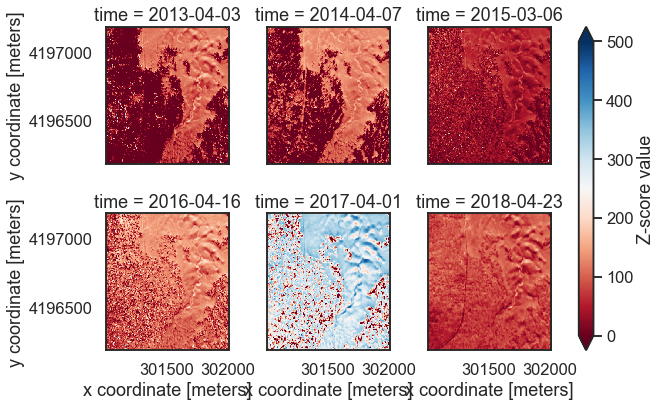

Met Station Name: Slide Canyon 
 station ID: SLI


<Figure size 1080x720 with 0 Axes>

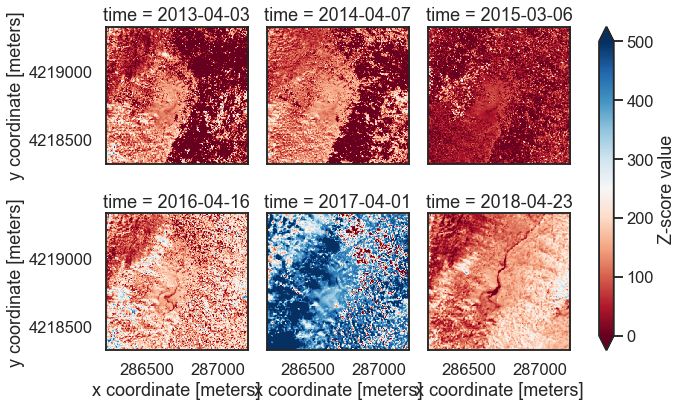

Met Station Name: Tuolumne Meadow 
 station ID: TUM


<Figure size 1080x720 with 0 Axes>

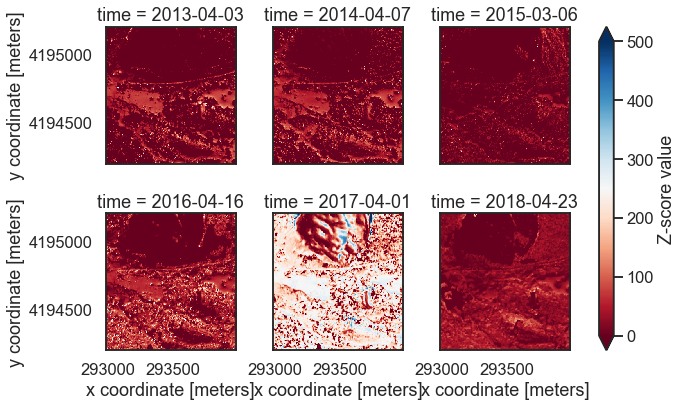

In [23]:
#Main, section 3:
stns = ['DAN','SLI','TUM'] #could make dict so it's always connected to the file, but shortcut is to do sorted(glob.glob) -- ie always loads in same order :/
stns_lc = ['dan','sli','tum']
stns_longname = ['Dana Meadow', 'Slide Canyon', 'Tuolumne Meadow']

for i, f in enumerate(zip(flist1, flist2)):
    
    f1, f2 = f
    
    print('Met Station Name:', stns_longname[i], '\n station ID:', stns[i])
    
    sns.set_style('white') # set up seaborn defaults (warnings w/o inside loop..?)
    sns.set_context("talk")

    ds = xr.open_dataset(f1); ds.close() #open lidar snow depth DataSet in Xarray -- ds
    ts = xr.open_dataset(f2); ts.close() #open terrain DataSet to access (hillslope, aspect, slope)
    
    z = z_score(ds, time=[0,7,18,30,42,49], exclude_zeros=True)
    plt.figure(figsize=(15, 10))
    z.plot.imshow(x='x', y='y', col='time', cmap='RdBu', col_wrap=3,  vmin=0, vmax=500, cbar_kwargs={'label': 'Z-score value'}); plt.show()

In [ ]:
#might use...reference

# # ~~~~~~ open each subregion as a single ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# open 3 different datasets
# dan = xr.open_dataset(flist[0]); dan.close()
# sli = xr.open_dataset(flist[1]); sli.close()
# tum = xr.open_dataset(flist[2]); tum.close()

#~~~~~PLANNED TO USE TERRAIN, BUT DONT NEED IT!? ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# # ~~~~~TERRAIN DATA - temp for hillshade, goal is to make terrain_clean and get hill,aspect,slope all going!
# #load lidar (needed to mask terrain layers)
# fname = '~/Documents/research/sierra/data/compiled_SUPERsnow.nc' #BSU
# ds = xr.open_dataset(fname,  chunks={'time':1,'x':1000,'y':1000}); ds.close()

# #load terrain layers
# path = '/Users/meganmason491/Documents/research/sierra/data/terrain/*.nc' #BSU
# fpath = glob.glob(path)
# terrain=xr.open_mfdataset(fpath, 
#                           concat_dim=None, 
#                           combine='nested', 
#                           chunks={'x':1000, 'y':1000}, 
#                           parallel=True).rename({'Band1':'hillshade'}).drop('transverse_mercator') 
# terrain.close()

# terrain_hill=np.flip(terrain.hillshade,0) #terrain needs to be flipped!
# terrain_hill=terrain_hill.where(ds.mask==1)
# terrain_hill=terrain_hill.to_dataset()
# terrain_hill.close()

# #terrain station slices
# pix = 75 #multipy by 3 to get x and y distance of box sz
# t_dan = terrain_hill.sel(x=slice(301506.-pix, 301506.+pix), y=slice(4196685.+pix, 4196685.-pix)) #x=301506.26, y=4196685.89
# t_tum = terrain_hill.sel(x=slice(293484.-pix, 293484.+pix), y=slice(4194702.+pix, 4194701.-pix)) #x=293484.72, y=4194701.07
# t_sli = terrain_hill.sel(x=slice(286708.-pix, 286710.+pix), y=slice(4218828.+pix, 4218826.-pix)) #x=286708.13, y=42188826.62 #due to rounding, made x and y have 2 pix apart


#~~~~~~~~~~~~~~ when my functions were just script.... :) ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# #dem
# levels = np.arange(dan.dem.min().values,dan.dem.max().values, 5) #5m contour interval
# h = dan.dem.plot.imshow(x='x', y='y', cmap='gray', alpha=.9, cbar_kwargs={'label': 'Elevation [m]'})
# c = dan.dem.plot.contour(x='x',y='y', levels=levels, colors='k', linewidths=.75)
# plt.clabel(c,levels, fmt='%1.0f')
# plt.show()

# #veg
# levels = np.arange(dan.dem.min().values,dan.dem.max().values, 5) #5m contour interval
# h = dan.veg.plot.imshow(x='x', y='y', cmap='Greens', alpha=.9, vmax=30, cbar_kwargs={'label': 'Vegetation Height [m]'})
# c = dan.dem.plot.contour(x='x',y='y', levels=levels, colors='k', linewidths=.75)
# plt.clabel(c,levels, fmt='%1.0f')
# plt.show()

#~~~~~~~~~~~~~~ flatten plots~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# april 26, 2016 vs elevation
# d = dan.plot(x='dem', y='snow', col='time')
# stns = ['dan','tum','sli']

# for stn in stns:

#     plt.scatter('{}.dem.values.flatten()'.format(stn), '{}.isel(time=31).snow.values.flatten()'.format(stn))
#     plt.show()

# flt_sno = sli.snow.isel(time=31).values.flatten()
# flt_dem = sli.dem.values.flatten()
# flt_veg = sli.veg.values.flatten()

# # elevation density
# fig = plt.figure(figsize=(10, 5))
# plt.hexbin(flt_dem, flt_sno, mincnt=1)
# plt.xlabel('Elevation [m]')
# plt.ylabel('snow depth [cm]')
# plt.title('Snow depth vs elevation')
# plt.colorbar()
# plt.show()

# fig = plt.figure(figsize=(10, 5))
# plt.hexbin(flt_veg, flt_sno, mincnt=1)
# plt.xlabel('Vegetation [m]')
# plt.ylabel('snow depth [cm]')
# plt.title('Snow depth vs vegetation')
# plt.colorbar()
# plt.show()
# plt.savefig('figs/bla', dpi=300)

#~~~~~~~~~~level~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# levels = np.around(np.arange(ds.dem.min().values, ds.dem.max().values, 50), -1)
# # levels = np.arange(ds.dem.min().values, ds.dem.max().values, 5)
# print(levels)
# # print(type(levels))

In [ ]:
#test stuff
dan = xr.open_dataset(flist1[0]); dan.close()
sli = xr.open_dataset(flist1[1]); sli.close()
tum = xr.open_dataset(flist1[2]); tum.close()

t_dan = xr.open_dataset(flist2[0]); t_dan.close()
t_sli = xr.open_dataset(flist2[1]); t_sli.close()
t_tum = xr.open_dataset(flist2[2]); t_tum.close()

t_dan.attrs

In [7]:
ds

<xarray.Dataset>
Dimensions:  (time: 51, x: 335, y: 335)
Coordinates:
  * x        (x) float32 292983.0 292986.0 292989.0 ... 293982.0 293985.0
  * y        (y) float32 4195203.0 4195200.0 4195197.0 ... 4194204.0 4194201.0
  * time     (time) datetime64[ns] 2013-04-03 2013-04-29 ... 2018-05-28
    mask     (y, x) uint8 ...
    dem      (y, x) float32 ...
    veg      (y, x) float32 ...
Data variables:
    snow     (time, y, x) int16 ...

In [14]:
for grp in ds.groupby('time.year'):
    print(type(grp))
    print(grp)
    ds[grp].snow.plot.imshow(x='x',y='y',col='time'); plt.show()

<class 'tuple'>
(2013, <xarray.Dataset>
Dimensions:  (time: 6, x: 335, y: 335)
Coordinates:
  * x        (x) float32 292983.0 292986.0 292989.0 ... 293982.0 293985.0
  * y        (y) float32 4195203.0 4195200.0 4195197.0 ... 4194204.0 4194201.0
  * time     (time) datetime64[ns] 2013-04-03 2013-04-29 ... 2013-06-08
    mask     (y, x) uint8 ...
    dem      (y, x) float32 ...
    veg      (y, x) float32 ...
Data variables:
    snow     (time, y, x) int16 0 0 10 14 7 8 4 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0)


KeyError: 2013